# l-1 trend filtering

В своей знаменитой статье [l-1 trend filtering](https://web.stanford.edu/~boyd/papers/l1_trend_filter.html) Стивен Бойд и его коллеги предложили подход к выявлению тренда в финансовых временных рядах с помощью выпуклой оптимизации. В частности, вместо построения стохастической модели временного ряда, они предложили отталкиваться от задачи - построить кусочно-линейную линию тренда, наилучшим образом аппроксимирующую данный временной ряд.

Это привело к задачи оптимизации следующего вида:

**TrendFilter problem**
$$
\min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1
$$
где $y \in R^T$ - временной ряд фактических цен акции (с момента времени $t = 1$ до момента времени $T$), матрица $D \in R^{(T-2) \times T}$ является трехдиагональной: $[Dx]_i = x_i - 2 \cdot x_{i+1} + x_{i+2} \quad$ ($1\leq i \leq T-2$).

Первый член в целевой функции отвечает за близость решения к фактическим данным, а второй форсирует решение  быть кусочно-линейной функцией с минимальным числом "изломов". 

В этой настоящей работе предлагаю сравнить некоторые методы оптимизации между собой на тестовых данных.

### 1. Скачаем данные акций Белуга ао с ноября 2021 по апрель 2022 с периодичностью в 1 час  с finam.ru.

In [7]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

from tqdm import tqdm


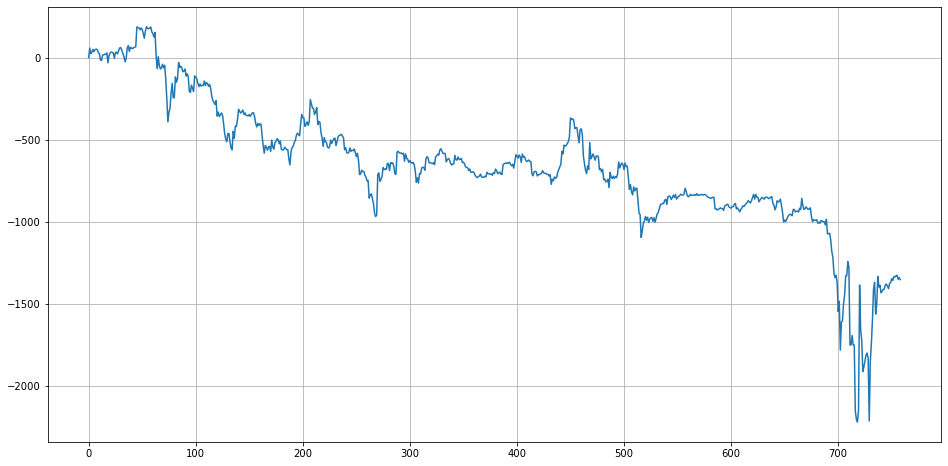

In [9]:
gazp_data = pd.read_csv("BELU.csv", sep=",")
share_clsng = np.array(gazp_data.loc[:, "<CLOSE>"])
data = []
for i in range(len(share_clsng)):
    data.append(share_clsng[i])
data -= data[0]
plt.figure(figsize=(16,8))
plt.plot(data)
plt.grid()

### 2. Выпишем двойственную задачу для задачи TrendFilter.

$$ \min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1 $$

Переформулируем задачу, введя новую переменную:

(P):
$$\min_{x \in R^T, ~z \in R^{T-2}} \frac{1}{2}\|y - x\|_2^2 + \lambda \|z\|_1$$
$$z = Dx$$

Лагранжиан:
$$
L(x, z, \mu) = \frac{1}{2}\|y - x\|_2^2 + \lambda \|z\|_1 + \mu^T(Dx - z)
$$

Тогда двойственная целевая функция: 
$$
g(\mu) = inf_{x, z} L(x, z, \mu)
$$

Выпишем условие оптимальности первого порядка для выпуклого Лагранжиана:
$$ 0 \in \partial L(x, z, \mu) $$
По теореме Моро-Рокафеллара:
$$ \partial L(x, z, \mu) = \frac{1}{2} \partial (\|y - x\|_2^2) + \lambda\partial ( \|z\|_1) + \partial(\mu^TDx ) - \partial(\mu^Tz) = \nabla_{x} \left(\frac{1}{2} (\|y - x\|_2^2) + (\mu^TDx )\right) + \sum_{i=1}^{T-2} (\lambda\partial |z_i| - \mu_i) $$
$$\partial |z_i| = \begin{cases}
                          -1,\  & z_i < 0, \\
                          1, \  & z_i > 0, \\
                          [-1,1],\ & z_i = 0.
                      \end{cases}
$$
$$\lambda \partial |z_i| - \mu_i = \begin{cases}
                          -\lambda - \mu_i,\  & z_i < 0, \\
                          \lambda - \mu_i, \  & z_i > 0, \\
                          [-\mu_i-\lambda,-\mu_i + \lambda],\ & z_i = 0.
                      \end{cases}
$$

$$ 0 \in \partial L(x, z, \mu) ~\Rightarrow ~ 0 \in (\lambda \partial |z_i| - \mu_i) ~\Rightarrow ~\begin{cases}
                          \lambda = -\mu_i,\  & z_i < 0, \\
                          \lambda = \mu_i, \  & z_i > 0, \\
                          0 \in [-\mu_i-\lambda,-\mu_i + \lambda]~ \Rightarrow ~-\lambda \preceq \mu_i \preceq \lambda,\ & z_i = 0.
                      \end{cases}
$$

$$
d\left(\frac{1}{2} (\|y - x\|_2^2) + (\mu^TDx )\right) = d(\frac{1}{2}<x - y, x - y> + <\mu, Dx>) = ~<d(x - y), x - y> + <\mu, Ddx> ~= 
$$ $$ = ~<x - y, dx> + <D^T\mu, dx>~ = ~<x - y + D^T\mu, dx>~ = ~<\nabla_{x} \left(\frac{1}{2} (\|y - x\|_2^2) + (\mu^TDx )\right), dx>$$

$$
0 \in \partial L(x, z, \mu)~ \Rightarrow ~x - y + D^T\mu = 0 ~\Leftrightarrow ~x^* = y - D^T\mu
$$

Заметим, что из $z_i > 0$ и $\lambda = \mu_i\Rightarrow \lambda \|z_i\|_1 - \mu_iz_i = 0$. Аналогично при $z_i < 0$ и $z_i = 0$. Подставив оптимальные $(x^*, z^*)$ в Лагранжиан, находим двойственную целевую функцию:

$$
g(\mu) = \frac{1}{2}\|D^T\mu\|_2^2 + \mu^T(D(y - D^T\mu)) = -\frac{1}{2}\mu^TDD^T\mu + \mu^TDy
$$

Тогда двойственная задача:
$$
\max_{\mu} -\frac{1}{2}\mu^TDD^T\mu + \mu^TDy
$$
$$
-\lambda \preceq \mu_i \preceq \lambda
$$
(D):
$$
\min_{\mu \in R^{T-2}} \frac{1}{2}\mu^TDD^T\mu - \mu^TDy
$$
 $$-\lambda \times 1_{T-2} \preceq \mu \preceq \lambda \times 1_{T-2}$$


### 3. Численно решим задачу используя проксимальный градиентный спуск.

Перепишем функцию в эквивалентном виде как показано в статье Бойда:

$$f(x)=\frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1 \Rightarrow f(\theta) =\frac{1}{2}\|A\theta-y\|_2^2 + \lambda \sum\limits_{x=3}^{n}\|\theta_i\|,$$

Где $\theta = (\theta_1,...,\theta_n) \in \mathbb{R}^n\$, а матрица А имеет следующий вид:

$$
A = \begin{pmatrix}
1  \\
1 & 1 \\
1 & 2 & 1 \\
1 & 3 & 2 & 1 \\
... \\
1 & n-1 & n-2 & ... & 2 & 1 
\end{pmatrix}$$

Решение $\theta$ этой задачи и оценка l-1 trend filtering связаны соотношением:

$$x = A\theta$$

Интерпретируем коэффициенты $\theta$:$\:$ $\theta_1 = x_1,\: \theta_2 = x_2 - x_1$ и для $k \geq 3,\: \theta_k = (Dx)_{k-2}$

Тогда $g(\theta) = \frac{1}{2}\|A\theta - y\|_2^2$ - выпуклая гладкая, а $h(\theta) = \lambda \sum\limits_{i=3}^{n} |\theta_i|$ -  выпуклая негладкая функция.

Воспользуемся проксимальным градиентным спуском:

$$
f(\theta,z) = g(\theta)  +  <\nabla g(\theta), z - \theta> + \frac{\nu}{2}\|z - \theta\|_2^2 + Dz~ \Rightarrow~ f(\theta,z) = f(\theta) ~\Leftrightarrow ~z = \theta
$$

$$
\theta^{k+1} = argmin_{z} f(\theta^k, ~z) = argmin_{z}(<\nabla g(\theta^k) + \frac{\nu}{2}(z - \theta^k),~ z - \theta^k> + Dz)
$$

$\theta^{k+1} = argmin_{z}(\frac{\nu}{2}<\frac{1}{\nu}\nabla g(\theta^k) + z - \theta^k, z - \theta^k> + <\frac{1}{\nu}\nabla g(\theta^k), z - \theta^k +  \frac{1}{\nu}\nabla g(\theta^k) - \frac{1}{\nu}\nabla g(\theta^k)> + Dz)=$

$= argmin_{z}(\frac{\nu}{2}\|\frac{1}{\nu}\nabla g(\theta^k) + z - \theta^k\|_2^2 - \|\frac{1}{\nu}\nabla g(\theta^k)\|_2^2 + Dz) = argmin_{z}(\frac{\nu}{2}\|\frac{1}{\nu}\nabla g(\theta^k) + z - \theta^k\|_2^2 + Dz) = prox_{h, \nu}(\theta^k - \frac{1}{\nu}\nabla g(\theta^k))$, где $h(z)=Dz$

$$prox_{h, \nu}(m) = argmin_{z}(\frac{\nu}{2}\|z - m\|_2^2 + \lambda \sum\limits_{i=3}^{n} |z_i|)$$

При $i < 3 ~\Rightarrow~ \; (z_i - m_i) = 0 ~\Rightarrow ~z_i = m_i$

При $i \geq 3~\Rightarrow~ \; 0 \in (\nu(z_i - m_i) + \lambda\partial|z_i|)$

Значит, при $i \geqslant 3$
$$
\begin{cases}
               z_i = m_i - \frac{\lambda}{\nu},  & m_i > \frac{\lambda}{\nu} ,\\
               z_i = m_i + \frac{\lambda}{\nu},  & m_i < -\frac{\lambda}{\nu} ,\\
               z_i = 0, & -\frac{\lambda}{\nu} \leqslant m_i \leqslant \frac{\lambda}{\nu}.
\end{cases}
$$

$$
<\nabla g(\theta), dx> ~= \frac{1}{2}(<A\theta - y, A d\theta> + <A d\theta, A\theta - y>~ \Rightarrow ~\nabla g(\theta) = A^T(A\theta - y)
$$

In [10]:
n = len(data)
A = np.eye(n)
for i in range(n):
    A[i][0] = 1
    for j in range(1, i):
        A[i][j] = i - j + 1
print(A)

[[  1.   0.   0. ...   0.   0.   0.]
 [  1.   1.   0. ...   0.   0.   0.]
 [  1.   2.   1. ...   0.   0.   0.]
 ...
 [  1. 756. 755. ...   1.   0.   0.]
 [  1. 757. 756. ...   2.   1.   0.]
 [  1. 758. 757. ...   3.   2.   1.]]


In [11]:
data = np.array(data)
y = data[:, np.newaxis] #переделываем строку в вектор-столбец
L = 5e10
lam_1 = 5e-12
def prox(x):
    grad = A.T.dot(A.dot(x) - y)
    next_x = x - grad/L
    for i in range(3, n):
        if next_x[i][0] > lam_1/L:
            next_x[i][0] -= lam_1/L
        elif next_x[i][0] < -lam_1/L:
            next_x[i][0] += lam_1/L
        else:
            next_x[i][0] = 0
    return next_x

  0%|          | 0/100000 [00:00<?, ?it/s]

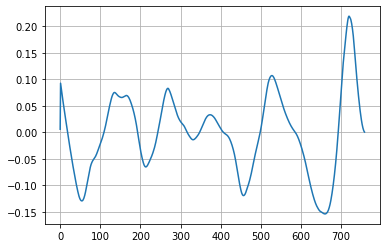

In [12]:
from tqdm.notebook import tqdm
theta = np.zeros((n, 1))
steps = 100000
for step in tqdm(range(steps)):
    theta = prox(theta)
plt.plot(theta)
plt.grid()

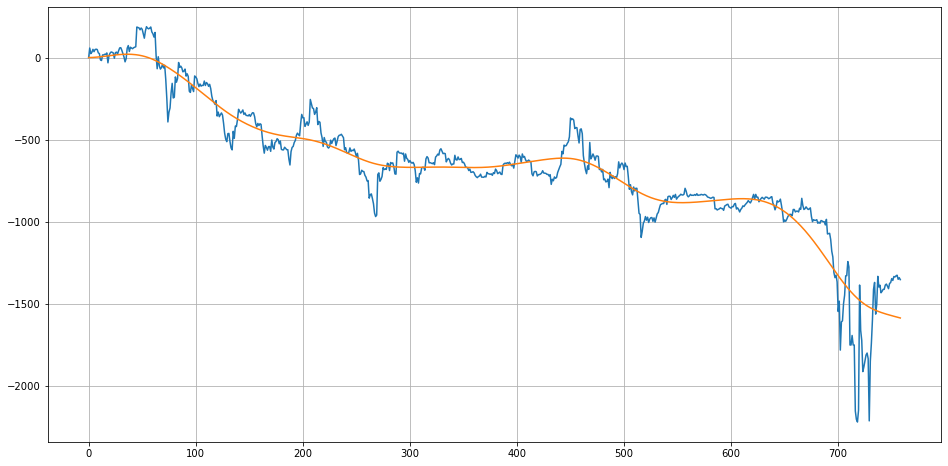

In [13]:
PL = A.dot(theta)
plt.figure(figsize=(16,8))
plt.plot(data)
plt.plot(PL)
plt.grid()

### 4. Выпишем сглаженную версию задачи Trend Filter и найдем ее решение используя метод быстрого градиентного спуска.

$$
f(x) = \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1 = \frac{1}{2}\|y - x\|_2^2 + \lambda \max\limits_{\|u\|_\infty \leqslant 1} (u^TDx) 
$$

Пусть $d_2(u)= \frac {1}{2}\|u\|_2^2$ -- сильновыпуклая по $u$ на $Q_2= \{u ~| ~\|u\|_\infty \leqslant 1\}$.

Тогда $D_2=\max\limits_{u \in Q_2} d_2(u) =  \frac {1}{2}\sum\limits_{1}^{n-2} (1^2) = \frac {n-2}{2} $.

Получили функцию $f_\mu (x) = \lambda\max\limits_{|u| \leqslant 1}(u^TDx - \frac{\mu}{2} \|u\|_2^2) + \frac{1}{2}\|y - x\|_2^2$.

Найдём максимум:
$$\max (u^TDx - \frac{\mu}{2} \|u\|_2^2) =\max \sum\limits_{i = 1}^{n-2} (u_i (Dx)_i - \frac{\mu}{2} u_i^2)= \sum\limits_{i = 1}^{n-2} \max(u_i (Dx)_i - \frac{\mu}{2} u_i^2)$$

Значит, $u_i^*$ - ближайшая к вершине параболы точка на $[-1,1]$, где вершина параболы $-\frac{b}{2a}=\frac{(Dx)_i}{\mu}$.

$$u_i^* = \begin{cases}
               \frac{(Dx)_i}{\mu},  & -\mu \leqslant  (Dx)_i \leqslant \mu ,\\
               1,  & (Dx)_i > \mu ,\\
               -1 & (Dx)_i < -\mu.
\end{cases}$$

$$
\nabla f_\mu(x)= (x - y) + \lambda D^Tu^*
$$

In [14]:
lam_2 = 5e3
n = len(data)
mu_1 = 1e-4

In [15]:
D = np.zeros((n-2, n))
for i in range(n-2):
    D[i][i] = 1
    D[i][i+1] = -2
    D[i][i+2] = 1
D

array([[ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.]])

In [16]:
y = data[:, None]
alpha = 0.99

In [17]:
def step_smooth(X, moment_grad, flag = False):
    u = D @ X / mu_1
    u[:, 0][u[:, 0] > 1] = 1
    u[:, 0][u[:, 0] < -1] = -1
    grad_cur = X - y + lam_2 * D.transpose() @ u
    new_grad = moment_grad * alpha + grad_cur * (1 - alpha)
    X_new = X - new_grad/ v
    if flag:
        return X_new, new_grad, 0.5 * ((X-y)**2).sum() + lam_2 *abs(D @ X).sum()
    return X_new, new_grad

In [18]:
X = np.zeros((n,1))
grad = np.zeros((n,1))

In [19]:
v = 1e5

In [21]:
epochs = 200000
s = ""
for epoch in tqdm(range(epochs)):
    if epoch % (epochs // 10) == 0:
        X, grad, ss = step_smooth(X, grad, True)
        s += f"Loss on epoch {epoch:6}= {ss}" + "\n"
    X, grad = step_smooth(X, grad)
print(s)

  0%|          | 0/200000 [00:00<?, ?it/s]

Loss on epoch      0= 226098306.3483346
Loss on epoch  20000= 152493298.35436514
Loss on epoch  40000= 103201836.87870002
Loss on epoch  60000= 70168945.39709449
Loss on epoch  80000= 48038903.11632697
Loss on epoch 100000= 33212562.10571165
Loss on epoch 120000= 23275784.93197409
Loss on epoch 140000= 16619933.951944184
Loss on epoch 160000= 12156473.131162636
Loss on epoch 180000= 9169116.162351573



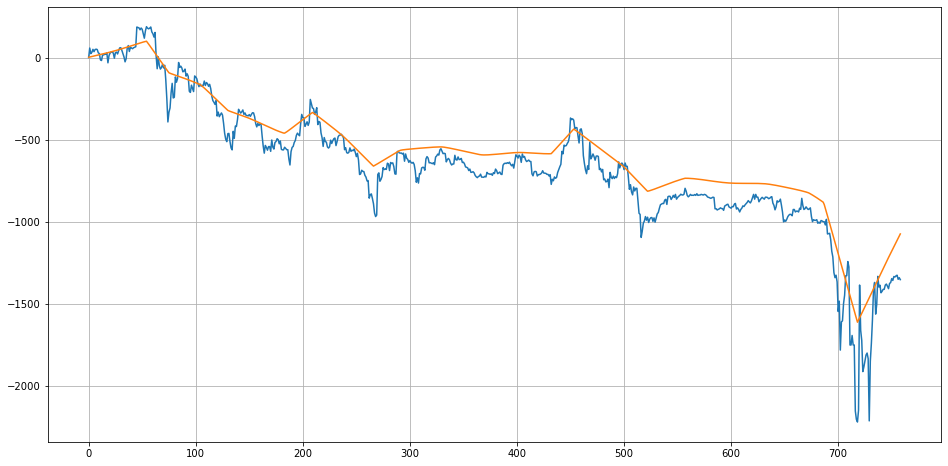

In [22]:
plt.figure(figsize=(16,8))
plt.plot(data)
plt.plot(X)
plt.grid()

### 5. Выпишем схему ADMM для решения задачи Trend Filter, реализуем ее и найдите численное решение задачи. 


$$ \min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1 $$

Переформулируем задачу, введя новую переменную:

$$\min_{x \in R^T, ~z \in R^{T-2}} \frac{1}{2}\|x - y\|_2^2 + \lambda \|z\|_1$$
$$Dx - z = 0$$

Выпишем модифицированную функцию Лагранжа:

$$L_r(x, z, \mu) = \frac{1}{2} \|x-y\|_2^2 +\lambda \|z\|_1 + \mu^T(Dx-z) + \frac{r}{2}\|Dx-z\|_2^2$$

ADMM:

$$\mu^{k+1} = \mu^k + r(Dx^k - z^k)$$

$$x^{k+1} = argmin_x L_r(x, z^k, \mu^{k+1})~ \Rightarrow [FOOC]~\Rightarrow~\nabla_x L_r(x, z, \mu) = 0$$

$$ (x-y) + D^T \mu + r D^T(Dx-z)=0$$

$$(I_T + r D^T D)x = y - D^T \mu + r D^T z$$

$$x^{k+1} = (I_T + r D^T D)^{-1} (y - D^T \mu^{k+1} + r D^T z^k)$$

$$z^{k+1} = argmin_z L_r(x^{k+1}, z, \mu^{k+1})~ \Rightarrow~ [FOOC]~\Rightarrow ~0 \in \partial_z L_r(x, z, \mu)$$ 

$$
0 \in -\mu_i + r(z_i - (Dx)_i) + \lambda  \begin{cases}
  1 , & z_i > 0,\\
  -1 , & z_i < 0,\\
  [-1;~1], & z_i = 0 
 \end{cases}
$$

$$
z^{k+1}_i = \begin{cases}
  Dx^{k+1}_i + \frac{1}{r}\mu^{k+1}_i - \frac{\lambda}{r}, & Dx^{k+1}_i + \frac{1}{r}\mu^{k+1}_i > \frac{\lambda}{r} , \\
  Dx^{k+1}_i + \frac{1}{r}\mu^{k+1}_i + \frac{\lambda}{r}, & Dx^{k+1}_i + \frac{1}{r}\mu^{k+1}_i < -\frac{\lambda}{r} , \\
  0, & -\frac{\lambda}{r} < (Dx^{k+1}_i + \frac{1}{r}\mu^{k+1}_i) < \frac{\lambda}{r} 
 \end{cases}
$$  



In [23]:
r = 5e4
In = np.eye(n)
lam_3 = 5e5
def admm(x, z, mu):
    next_mu = mu + r*(D.dot(x) - z)
    next_x = np.linalg.inv(In + r*D.T.dot(D)).dot(y - D.T.dot(mu - r * z))
    next_z = D.dot(x) + mu/r
    for i in range(n - 2):
        if z[i][0] > lam_3/r:
            z[i][0] -= lam_3/r
        elif z[i][0] < - lam_3/r:
            z[i][0] += lam_3/r
        else:
            z[i][0] = 0
    return next_x, next_z, next_mu

In [26]:
mu_2 = np.zeros((n - 2, 1))
x = np.zeros((n, 1))
z = np.zeros((n-2, 1))
steps = 1000
for step in tqdm(range(steps)):
    x, z, mu_2 = admm(x, z, mu_2)

  0%|          | 0/1000 [00:00<?, ?it/s]

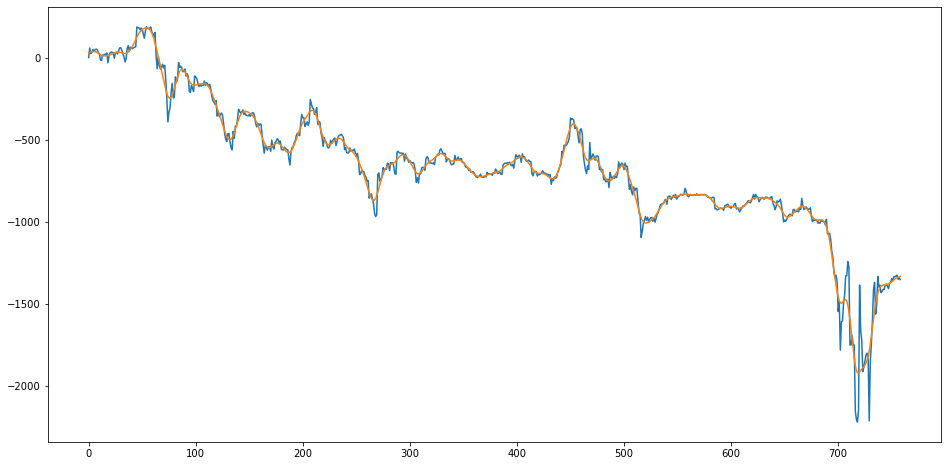

In [27]:
plt.figure(figsize=(16,8))
plt.plot(data)
plt.plot(x)

### 6. Сравним полученные результаты на тестовых данных.

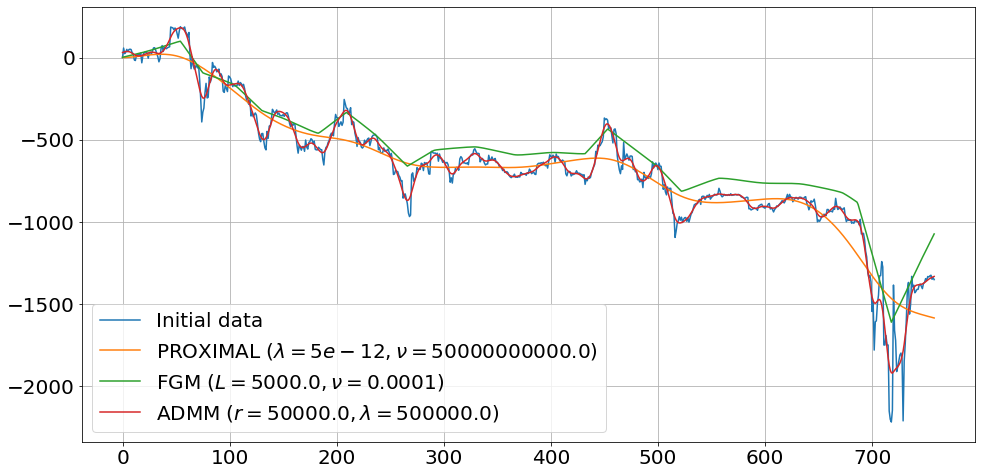

In [28]:
plt.figure(figsize=(16,8))
plt.plot(data, label ="Initial data")
plt.plot(PL, label = r"PROXIMAL $(\lambda = {}, \nu = {})$".format(lam_1, L))
plt.plot(X, label = r"FGM $(L = {}, \nu = {})$".format(lam_2, mu_1))
plt.plot(x, label = r"ADMM $(r = {}, \lambda = {})$".format(r, lam_3))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)